# k-min-sum-radii ilp proof of concept

In [1]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.metrics import DistanceMetric

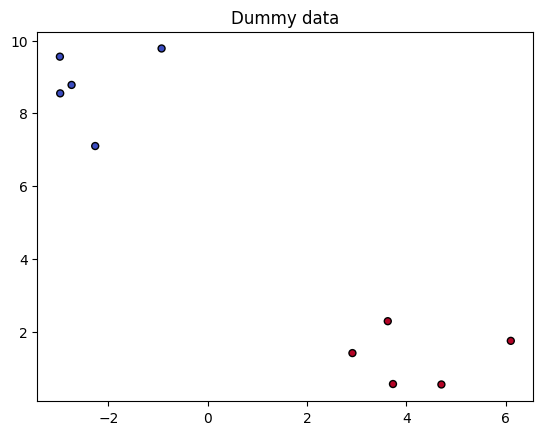

In [2]:
# generate dummy data
points, cluster_membership = make_blobs(
    n_samples=10,
    n_features=2,
    centers=2,
    random_state=42
)

plt.title("Dummy data")
plt.scatter(points[:, 0], points[:, 1], marker='o', c=cluster_membership, s=25, edgecolor="k", cmap="coolwarm")
plt.show()

## Defining the ILP

In [3]:
# distance function
dist = DistanceMetric.get_metric('euclidean')

# we need all distances as possible radii
radii = dist.pairwise(points)

In [4]:
# model
m = gp.Model("kmsr")

# variables
R = m.addVars(len(radii), vtype=GRB.CONTINUOUS, lb=0, name="R")
L = m.addVars(len(radii), vtype=GRB.BINARY, name="L")
Y = m.addVars(len(radii), len(radii), vtype=GRB.BINARY, name="Y")

Set parameter Username
Set parameter LicenseID to value 2629995
Academic license - for non-commercial use only - expires 2026-03-01


In [5]:
# objective function: minimize sum of r in R_i of i in L: y_{i,r}*r
m.setObjective(gp.quicksum(R[i] for i in range(len(radii))), GRB.MINIMIZE)

In [6]:
# constraints:
# every point covered
for j in range(len(radii)):
    m.addConstr(gp.quicksum(Y[i, j] for i in range(len(radii))) >= 1, f"coverage_{j}")

# covered point has to be within radius (easier to check in two steps than in the first constraint)
for i in range(len(radii)):
    for j in range(len(radii)):
        m.addConstr(radii[i][j] * Y[i, j] <= R[i], f"within_radius_{i}_{j}")

# if a point is covered by a center, that center must be open in this iteration
for i in range(len(radii)):
    for j in range(len(radii)):
        m.addConstr(Y[i, j] <= L[i], f"open_center_{i}_{j}")

In [7]:
# run gurobi optimizer
m.optimize()

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 7 5800X3D 8-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 210 rows, 120 columns and 490 nonzeros
Model fingerprint: 0xbdb126fc
Variable types: 10 continuous, 110 integer (110 binary)
Coefficient statistics:
  Matrix range     [3e-01, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 34.3266646
Presolve removed 210 rows and 120 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 16 available processors)

Solution count 2: 0 34.3267 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%


In [8]:
if m.status == GRB.OPTIMAL:
    print("Optimal Solution Found!")
    for i in range(len(radii)):
        if L[i].x > 0.5:  # If the center is used
            print(f"Center at point {points[i]} with radius {R[i].x}")
else:
    print("No optimal solution found.")

Optimal Solution Found!
Center at point [2.914961   1.41088215] with radius 0.0
Center at point [-2.97261532  8.54855637] with radius 0.0
Center at point [-0.92998481  9.78172086] with radius 0.0
Center at point [3.62704772 2.28741702] with radius 0.0
Center at point [-2.743351    8.78014917] with radius 0.0
Center at point [3.73185476 0.56086598] with radius 0.0
Center at point [4.70740704 0.5484215 ] with radius 0.0
Center at point [-2.26723535  7.10100588] with radius 0.0
Center at point [-2.97867201  9.55684617] with radius 0.0
Center at point [6.10552761 1.74739338] with radius 0.0


In [9]:
distances = dist.pairwise(points)
L = np.zeros((len(points), len(points)), dtype=np.int8)

for i in range(len(L)):
    for j in range(len(L[i])):
        for r in R:
            if(R[i][j] >= R[i][0]):
                L[i][j] = 1

L


TypeError: 'Var' object is not subscriptable